In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from IPython import display
import matplotlib.pyplot as plt
from itertools import count
import datetime as dt

In [3]:
from env_factory import EnvFactory
from screen_convert import CartPoleScreenConverter
from state_gen import SimpleStateGenerator, StackStateGenerator
from trainer import DQNTrainer
from eval import Evaluator


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def plot_durations(episode_durations: list):
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    plt.pause(0.001)  # pause a bit so that plots are updated

In [5]:
def episode_end_callback(cur_episode: int, cur_episode_duration: int, episode_durations: list):
    plot_durations(episode_durations=episode_durations)

In [6]:
RESULT_TAG = "stack_state_4frames_greyscale_memory50k_episode10k_dpsdecay10k_adam0.0005_noncenter_fc128_2conv16-32_stepupdate1000_gamma0.9_ddqn_nonclip"

NUM_STACK = 4

In [7]:
env_factory = EnvFactory("CartPole-v1")

In [8]:
train_env = env_factory.gen_env(num_stack=NUM_STACK, human_render_mode=False)

In [9]:
screen_converter = CartPoleScreenConverter(resize_min=40, to_greyscale=True, center_cart=False)

In [10]:
# simple_state_generator = SimpleStateGenerator(screen_converter=CartPoleScreenConverter())
stack_state_generator = StackStateGenerator(screen_converter=screen_converter)

In [11]:
trainer = DQNTrainer(env=train_env,
                     state_generator=stack_state_generator,
                     n_actions=train_env.action_space.n,
                     device=device,
                     memory_size=50000,
                     eps_decay_steps=10000,
                     use_adam=True,
                     lr=0.0005,
                     use_ddqn=True,
                     target_update_episodes=1000,
                     target_update_step_mode=True, 
                     gamma=0.9)

In [12]:
print(trainer.model_info)

Layer (type:depth-idx)                   Output Shape              Param #
DQN                                      [128, 2]                  --
├─Conv2d: 1-1                            [128, 16, 18, 73]         1,616
├─BatchNorm2d: 1-2                       [128, 16, 18, 73]         32
├─Conv2d: 1-3                            [128, 32, 7, 35]          12,832
├─BatchNorm2d: 1-4                       [128, 32, 7, 35]          64
├─Linear: 1-5                            [128, 128]                1,003,648
├─Linear: 1-6                            [128, 2]                  258
Total params: 1,018,450
Trainable params: 1,018,450
Non-trainable params: 0
Total mult-adds (M): 802.72
Input size (MB): 12.29
Forward/backward pass size (MB): 59.25
Params size (MB): 4.07
Estimated Total Size (MB): 75.61


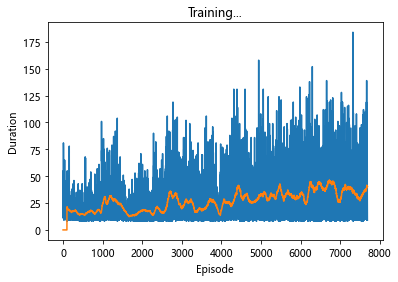


KeyboardInterrupt



In [13]:
trainer.train(num_episodes=10000, episode_end_callback=episode_end_callback)

In [ ]:
policy_net = trainer._policy_net

In [ ]:
eval_env = env_factory.gen_env(num_stack=NUM_STACK, human_render_mode=True)

In [ ]:
evaluator = Evaluator(env = eval_env,
                     state_generator = stack_state_generator,
                     device = device,
                     policy_net=policy_net)

In [ ]:
eval_result = evaluator.run()

In [ ]:
eval_result.save(name=f"{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}_{RESULT_TAG}")